# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.Define the model class.

In [2]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            # model layers
            # here we add 0.2 dropout rate to avoid overfitting problem

            # first layer with ReLU activation function
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),  # dropout of probability 0.2

            # second layer with ReLU activation function
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),  # dropout of probability 0.2

            # third layer with ReLU activation function
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),  # dropout of probability 0.2

            # output layer with Sigmoid activation function
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()

        )

    # YOUR CODE HERE
    # define the forward pass
    def forward(self, x):
        # pass through the self.mlp_stack
        logits = self.mlp_stack(x)
        return logits


#### Divide the dataset into a 75:25 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

2.Split the dataset and do preprocessing.

In [3]:
from common_utils import split_dataset, preprocess_dataset


def preprocess(df):
    # YOUR CODE HERE
    # drop useless columns for X
    columns_to_drop = ['filename', 'label']

    # perform data splitting
    X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop=columns_to_drop, test_size=0.25, random_state=100)

    # scaling the data using standard_scaler
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

3.Define a Pytorch Dataset and Dataloaders.  

In [4]:
class CustomDataset(Dataset):
    # YOUR CODE HERE
    def __init__(self, X, y):
    # convert data to tensors
    # note that long type is needed for y to prevent exception
        self.X =torch.tensor(X, dtype=torch.float)
        self.y =torch.tensor(y, dtype=torch.long)

    # return size of data
    def __len__(self):
        return len(self.y)

    # return data with given index
    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
    # load data
    train_data = CustomDataset(X_train_scaled, y_train)
    test_data = CustomDataset(X_test_scaled, y_test)

    # convert to DataLoader for batch processing and shuffling
    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

4.Next, define the model, optimizer and loss function.

In [5]:
# YOUR CODE HERE
no_features = 77 # feature number
no_hidden = 128  # neuron number of hidden layers
no_labels = 1  # output label number
lr = 0.001  # learning rate

# initialize model
model = MLP(no_features, no_hidden, no_labels)

# set Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr)

# apply cross entropy loss
loss_fn = nn.BCELoss()

D:\Program Files\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


5.Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [6]:
# YOUR CODE HERE
from common_utils import EarlyStopper

# training function
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    model.train()  # inform Dropout layer to work

    for X, y in dataloader:
        # forward pass and compute loss
        pred = model(X).reshape(-1)
        loss = loss_fn(pred, y.float())

        # back-prop and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update loss and correct number
        train_loss += loss.item() * X.size(0)
        correct += ((pred > 0.5).long() == y).type(torch.float).sum().item()
    
    train_loss /= size
    train_acc = correct / size
    return train_loss, train_acc

# testing function
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    model.eval()  # inform no dropout during testing

    with torch.no_grad():
        for X, y in dataloader:
            # forward pass
            pred = model(X).reshape(-1)
            test_loss += loss_fn(pred, y.float()).item() * X.size(0)
            correct += ((pred > 0.5).long() == y).type(torch.float).sum().item()

    test_loss /= size
    test_acc = correct / size
    return test_loss, test_acc


train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []
no_epochs = 100

# initialize early stopper
early_stopper = EarlyStopper(patience=3, min_delta=0)

# start training
for epoch in range(no_epochs):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)

    train_loss_.append(train_loss), train_acc_.append(train_acc)
    test_loss_.append(test_loss), test_acc_.append(test_acc)

    print(f"Epoch {epoch+1}, train_loss {train_loss:>7f} train_acc {train_acc:>4f}, test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")
    
    # early stop setting
    if early_stopper.early_stop(test_loss): 
        print("Early stopping!")
        break
print("Done!")

Epoch 1, train_loss 0.686614 train_acc 0.543906, test_loss 0.675739, test_acc 0.581758
Epoch 2, train_loss 0.671279 train_acc 0.583278, test_loss 0.664198, test_acc 0.617910
Epoch 3, train_loss 0.650875 train_acc 0.614908, test_loss 0.649950, test_acc 0.623549
Epoch 4, train_loss 0.637391 train_acc 0.635368, test_loss 0.651127, test_acc 0.617247
Epoch 5, train_loss 0.618744 train_acc 0.659478, test_loss 0.624334, test_acc 0.652405
Epoch 6, train_loss 0.596657 train_acc 0.678279, test_loss 0.623419, test_acc 0.634494
Epoch 7, train_loss 0.579011 train_acc 0.694426, test_loss 0.599455, test_acc 0.673632
Epoch 8, train_loss 0.564430 train_acc 0.708582, test_loss 0.578951, test_acc 0.689884
Epoch 9, train_loss 0.543397 train_acc 0.719199, test_loss 0.568001, test_acc 0.696186
Epoch 10, train_loss 0.534316 train_acc 0.726167, test_loss 0.577048, test_acc 0.697181
Epoch 11, train_loss 0.517863 train_acc 0.741982, test_loss 0.566284, test_acc 0.710116
Epoch 12, train_loss 0.502143 train_acc 0

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


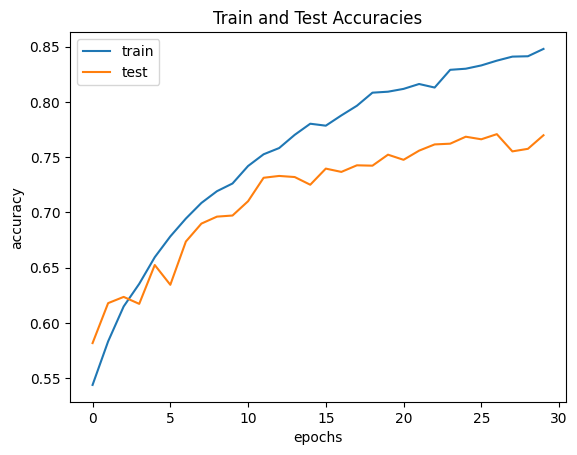

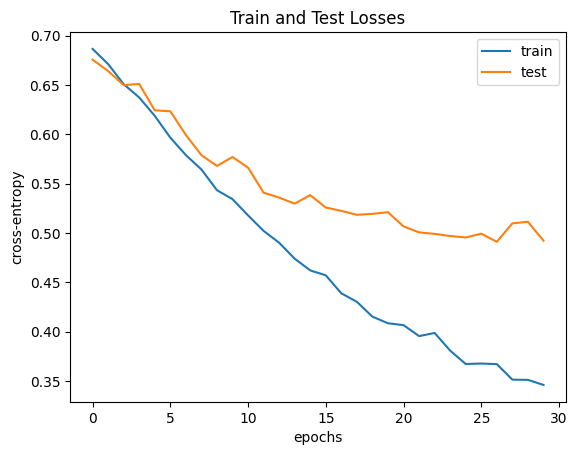

In [7]:
# YOUR CODE HERE
no_epochs = len(train_acc_)

# plot accuracies
plt.figure(1)
plt.plot(range(no_epochs), train_acc_, label='train')
plt.plot(range(no_epochs), test_acc_, label ='test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("Train and Test Accuracies")
plt.legend()

# plot losses
plt.figure(2)
plt.plot(range(no_epochs), train_loss_, label='train')
plt.plot(range(no_epochs), test_loss_, label ='test')
plt.xlabel('epochs')
plt.ylabel('cross-entropy')
plt.title("Train and Test Losses")
plt.legend()

6.Comment on line plots.

In [8]:
# YOUR CODE HERE
answer = "We can see training losses keep decreasing, which means the model is keep fitting the training data, while test losses decrease at first but stop decreasing after some epochs and even tend to increase."\
         "Similarly, training accuracies keep increasing, while test accuracies increase at first but start to plateau after some epochs."\
         "Therefore, after certain numbers of epochs, the early stopper is triggered to stop the training process in order to prevent overfitting."\
         "There is also a small gap between training losses and test losses, which is also observed between training accuracies and test accuracies."\
         "It indicates the distribution difference between the training and the test data, which makes the model perform good at training data but less good at test data."